In [220]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.data import Dataset

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.callbacks import History
from keras import callbacks
from keras import metrics
from keras import backend as K

from sklearn.metrics import confusion_matrix, accuracy_score 
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

import os, time
import matplotlib.pyplot as plt
import numpy as np
from datetime import timedelta
from tqdm import tqdm

import pandas as pd

In [142]:
DATA_PATH = "../../Data/"

IMAGES_PATH_SEPARATED = DATA_PATH+"HAM10000_images_separated/"
IMAGES_PATH_VALIDATION = DATA_PATH+"HAM10000_images_separated_validation/"

IMG_SIZE = (450, 600) # original image size

In [3]:
SAVING_ON = True

## Activation Function Choise

https://towardsdatascience.com/how-to-choose-the-right-activation-function-for-neural-networks-3941ff0e6f9c

For CNN developed, 3 major activation functions were taken into consideration: swish, relu and softmax.

Relu function does not have the vanishing gradient problem, computationaly inexpensive, faster convergence. 

## Functions

#### Mish Activation

In [4]:
## Mish Activation Function
def mish(x):
    return keras.layers.Lambda(lambda x: x*K.tanh(K.softplus(x)))(x)

#### Compile

In [31]:
def compile_model(input_shape: tuple, num_classes: int) -> Sequential:
    
    dropout_rate = 0.4
    regularization = 0.005
    learning_rate = 0.001
    # Rescaling is Standartization of the data, this layer will be used with colors 
    # to convert values from 0-255 into 0-1 range. This step is done to normalize data 
    # for Neural Network, key is to have mean value as close to 0 as possible, 
    # this will speed up learning and will provide faster convergence.
    
    model = Sequential([
        #data_augmentation,
        layers.Resizing(112,150),
        layers.Rescaling(1./255, input_shape=(112,150,3)),
         
        layers.Conv2D(16, (3,3), padding="same", activation=mish, 
                      kernel_regularizer=keras.regularizers.l2(regularization)),
        #layers.BatchNormalization(),
        layers.MaxPooling2D(),
        #layers.AveragePooling2D(),
        #layers.Dropout(dropout_rate),
        
        layers.Conv2D(32, (3,3), padding="same", activation=mish,
                     kernel_regularizer=keras.regularizers.l2(regularization)),
        #layers.BatchNormalization(momentum=0.8),
        layers.MaxPooling2D(),
        #layers.AveragePooling2D(),
        #layers.Dropout(dropout_rate),
        
        layers.Conv2D(64, (3,3), padding="same", activation=mish,
                     kernel_regularizer=keras.regularizers.l2(regularization)),
        layers.BatchNormalization(momentum=0.8),
        layers.MaxPooling2D(),
        #layers.AveragePooling2D(),
        layers.Dropout(dropout_rate),
                
        layers.Flatten(),
        layers.Dense(128, activation=mish,
                     kernel_regularizer=keras.regularizers.l2(regularization)),
        #layers.BatchNormalization(),
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes) # default linear activation
    ])
    
    # Try focal loss for uneven class distribution
    # Adagrad - Adaptive Gradient
    optimizer = keras.optimizers.Adagrad() # Adam(learning_rate=learning_rate)
    
    # SparseCategoricalCrossentropy is used because 
    # image_dataset_from_directory function returns integer labels
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=["accuracy"])
    return model
    
    
    
    '''
    # ACC 81 VAL 77
    
    dropout_rate = 0.4
    regularization = 0.005
    
    model = Sequential([
        #data_augmentation,
        layers.Resizing(112,150),
        layers.Rescaling(1./255, input_shape=(112,150,3)),
         
        layers.Conv2D(16, (3,3), padding="same", activation=mish, 
                      kernel_regularizer=keras.regularizers.l2(regularization)),
        #layers.BatchNormalization(),
        layers.MaxPooling2D(),
        #layers.AveragePooling2D(),
        #layers.Dropout(dropout_rate),
        
        layers.Conv2D(32, (3,3), padding="same", activation=mish,
                     kernel_regularizer=keras.regularizers.l2(regularization)),
        #layers.BatchNormalization(momentum=0.8),
        layers.MaxPooling2D(),
        #layers.AveragePooling2D(),
        #layers.Dropout(dropout_rate),
        
        layers.Conv2D(64, (3,3), padding="same", activation=mish,
                     kernel_regularizer=keras.regularizers.l2(regularization)),
        layers.BatchNormalization(momentum=0.8),
        layers.MaxPooling2D(),
        #layers.AveragePooling2D(),
        layers.Dropout(dropout_rate),
                
        layers.Flatten(),
        layers.Dense(128, activation=mish,
                     kernel_regularizer=keras.regularizers.l2(regularization)),
        #layers.BatchNormalization(),
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes) # default linear activation
    ])
    
    # Try focal loss for uneven class distribution
    # Adagrad - Adaptive Gradient
    optimizer = keras.optimizers.Adagrad() # Adam(learning_rate=learning_rate)
    
    # SparseCategoricalCrossentropy is used because 
    # image_dataset_from_directory function returns integer labels
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=["accuracy"]) #, run_eagerly=True)
    return model

    ''';
    
    
    '''
    # VAL_ACC ~75
    model = Sequential([
        #data_augmentation,
        layers.Resizing(112,150),
        layers.Rescaling(1./255, input_shape=(112,150,3)),
         
        layers.Conv2D(16, 3, padding="same", activation=mish, 
                      kernel_regularizer=keras.regularizers.l2(regularization)),
        layers.MaxPooling2D(),
        #layers.Dropout(dropout_rate),
        
        layers.Conv2D(32, 3, padding="same", activation=mish,
                     kernel_regularizer=keras.regularizers.l2(regularization)),
        layers.MaxPooling2D(),
        #layers.Dropout(dropout_rate),
        
        layers.Conv2D(64, 3, padding="same", activation=mish,
                     kernel_regularizer=keras.regularizers.l2(regularization)),
        layers.MaxPooling2D(),
        #layers.Dropout(dropout_rate),
                
        layers.Flatten(),
        layers.Dense(128, activation=mish,
                     kernel_regularizer=keras.regularizers.l2(regularization)),
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes)
    ])
    
    optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=["accuracy"]) #, run_eagerly=True)
    return model
    ''';

'''

def compile_model(input_shape: tuple, num_classes: int) -> Sequential:
    model = Sequential([
        #data_augmentation,
        layers.Resizing(112,150),
        layers.Rescaling(1./255, input_shape=input_shape),
        
        layers.Conv2D(16, 3, padding="same", activation="relu"),
        layers.Conv2D(16, 1, padding='same', activation="relu"),
        layers.Conv2D(16, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        
        layers.Conv2D(32, 3, padding="same", activation="relu"),
        layers.Conv2D(32, 1, padding='same', activation="relu"),
        layers.Conv2D(32, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        
        layers.Conv2D(64, 3, padding="same", activation="relu"),
        layers.Conv2D(64, 1, padding='same', activation="relu"),
        layers.Conv2D(64, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        
        layers.Conv2D(128, 3, padding="same", activation="relu"),
        layers.Conv2D(128, 1, padding='same', activation="relu"),
        layers.Conv2D(128, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(num_classes)
    ])

    model.compile(optimizer="adam",
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=["accuracy"])
    return model



''';

'''

def compile_model(input_shape: tuple, num_classes: int) -> Sequential:
    model = Sequential([
        #data_augmentation,
        layers.Resizing(112,150),
        layers.Rescaling(1./255, input_shape=input_shape),
        
        layers.Conv2D(16, 3, padding="same", activation=mish),
        layers.Conv2D(16, 1, padding='same', activation=mish),
        layers.Conv2D(16, 3, padding="same", activation=mish),
        layers.MaxPooling2D(),
        #layers.Dropout(0.2),
        
        layers.Conv2D(32, 3, padding="same", activation=mish),
        layers.Conv2D(32, 1, padding='same', activation=mish),
        layers.Conv2D(32, 3, padding="same", activation=mish),
        layers.MaxPooling2D(),
        #layers.Dropout(0.2),
        
        layers.Conv2D(64, 3, padding="same", activation=mish),
        layers.Conv2D(64, 1, padding='same', activation=mish),
        layers.Conv2D(64, 3, padding="same", activation=mish),
        layers.MaxPooling2D(),
        #layers.Dropout(0.2),
        
        layers.Conv2D(128, 3, padding="same", activation=mish),
        layers.Conv2D(128, 1, padding='same', activation=mish),
        layers.Conv2D(128, 3, padding="same", activation=mish),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        
        layers.Flatten(),
        layers.Dense(128, activation=mish),
        #layers.Dropout(0.2),
        layers.Dense(num_classes, activation="softmax")
    ])

    model.compile(optimizer="adam", learning_rate=0.0001
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=["accuracy"])
    return model
''';


'''
# ORIGINAL
def compile_model(input_shape: tuple, num_classes: int) -> Sequential:
    model = Sequential([
        #data_augmentation,
        layers.Rescaling(1./255, input_shape=input_shape),
        layers.Conv2D(16, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        layers.Conv2D(32, 3, padding='same', activation="relu"),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        layers.Conv2D(64, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(num_classes)
    ])

    model.compile(optimizer="adam",
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=["accuracy"])
    return model

''';

#### Fit Model

In [6]:
def fit_model(model: Sequential, train_ds: Dataset, test_ds: Dataset, 
              epochs: int=10, augment: str="no_augment", verbose: bool=True) -> None:
    global SAVING_ON
    
    trigger = callbacks.EarlyStopping(monitor="val_accuracy", mode="max", min_delta=0.001,
                                      patience=15, restore_best_weights=True)

    history = model.fit(train_ds, validation_data=test_ds, epochs=epochs, callbacks=[trigger])
    epochs = len(history.history['loss'])
    print("Epoch Length        : {0}".format(epochs))
    
    if verbose:
        evaluate_model(model, train_ds, test_ds)
        print_training_history(history, epochs)
    
    if SAVING_ON:
        model.save("output\keras_models\skin_classifier_{0}_{1}.keras".format(epochs, augment))

#### Evaluate

In [7]:
def evaluate_model(model: Sequential, train_ds: Dataset, test_ds: Dataset) -> None:
    acc_value = model.evaluate(train_ds, verbose=0)[1]
    val_acc_value = model.evaluate(test_ds, verbose=0)[1]
    print("Model Accuracy      : {0:.4f}".format(acc_value))
    print("Validation Accuracy : {0:.4f}".format(val_acc_value))

#### Training History

In [8]:
def print_training_history(history: History, epochs: int) -> None:
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs_range = range(epochs)

    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label="Training Accuracy")
    plt.plot(epochs_range, val_acc, label="Validation Accuracy")
    plt.legend(loc="lower right")
    plt.xlabel("Epochs")
    plt.title("Training and Validation Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label="Training Loss")
    plt.plot(epochs_range, val_loss, label="Validation Loss")
    plt.legend(loc="upper right")
    plt.xlabel("Epochs")
    plt.title("Training and Validation Loss")
    plt.show()

#### Filters and Weights

In [133]:
def print_filters(model: Sequential, plot_weights: bool=False, 
                  test_img_path: str="input/ISIC_0024891.jpg") -> None:
    
    # Dynamically get convolution layer indexes from model
    layer_indx = [i for i,layer in enumerate(model.layers) if "Conv" in str(layer)]

    for layer_i in layer_indx:
        conv_layer = model.layers[layer_i]
        print("Filters     : {0}".format(conv_layer.filters))
        print("Kernel Size : {0}".format(conv_layer.kernel_size))
        
        # Recreate model with a single layer        
        model_t = keras.Model(inputs=model.inputs, outputs=conv_layer.output)

        # Convert image to array
        img = load_img(test_img_path, target_size=(450, 600))
        img = img_to_array(img)
        img = np.expand_dims(img, axis=0)

        # plot all maps (filters)
        feature_maps = model_t.predict(img)

        cols = 8
        rows = int(conv_layer.filters/cols)

        for i in range(rows*cols):
            ax = pyplot.subplot(cols, cols, i+1)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            plt.imshow(feature_maps[0, :, :, i], cmap='gray')

        # show the figure
        plt.show();

        # Plot Filter Weights
        if plot_weights:
            x1w = conv_layer.get_weights()[0][:,:,0,:]
            for i in range(0,conv_layer.filters):
                ax = plt.subplot(cols, cols, i+1)
                ax.set_xticks([])
                ax.set_yticks([])
                plt.imshow(x1w[:,:,i], interpolation="nearest", cmap="gray")
            plt.show();

#### Confusion Matrix

In [265]:
def print_confusion_matrix(model: Sequential, val_image_path: str, 
                           normalize: bool=False) -> pd.DataFrame:
    global IMG_SIZE
    # Get validation images
    image_ds_validation = tf.keras.preprocessing.image_dataset_from_directory(
            val_image_path,
            image_size=img_size,
            batch_size=32,
            shuffle=False
        )
    # Get actual y (Truth)
    y = np.concatenate([y for x, y in image_ds_validation], axis=0)
    
    # Make predictions using existing model
    y_pred = model.predict(image_ds_validation)
    # Convert arrays of predictions into integers
    y_pred_int = np.argmax(y_pred, axis=1)

    # Display Confusion Matrixes (normalized and not)
    cm = confusion_matrix(y, y_pred_int, normalize=("true" if normalize else None) )
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names).plot();
    
    # Here Recall is Sensitivity
    print("Accuracy Score : ", round(accuracy_score(y, y_pred_int),4))
    # Replaced by DataFrame with added Specificity
    #print("Classification Report :\n", classification_report(y, y_pred_int))
    
    # Get data from classification report and parse it
    cr = classification_report(y, y_pred_int, digits=4, zero_division=0)
    cr = cr[:cr.index("accuracy")]
    
    # Remove unwanted spaces 
    while cr.find("  ") > -1:
        cr = cr.replace("  "," ")
    cr = "\n".join([row.strip() for row in cr.split("\n") if row.strip()])
    
    # Create Pandas DataFrame from String
    c_report = StringIO(cr)
    df = pd.read_csv(c_report, sep=" ")
    
    # Calculate Specificity
    specificity = []
    tn_total = 0
    for i in range(len(class_names)):
        tn_total += cm[i,i]
    
    for i in range(len(class_names)):
        tn = tn_total - cm[i,i] # total True Negatives minus current cell
        fp = sum(cm[:,i]) - cm[i,i] # current column minus current cell
        specificity.append( round(tn/(tn+fp), 4))
    df["specificity"] = specificity
    
    # Change columns name and order
    df.rename(columns={"recall":"sensitivity"}, inplace=True)
    columns = df.columns.tolist()
    columns = columns[0:2] + columns[4:] + columns[2:4]
    df = df[columns]
    
    return df

## KFold

Found 9013 files belonging to 7 classes.


  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

 --- KFold Iteration 1 --- 
Epoch 1/150
226/226 [==============================] - 81s 339ms/step - loss: 2.6297 - accuracy: 0.6548 - val_loss: 2.4236 - val_accuracy: 0.7031
Epoch 2/150
226/226 [==============================] - 77s 325ms/step - loss: 2.5051 - accuracy: 0.6816 - val_loss: 2.3729 - val_accuracy: 0.7115
Epoch 3/150
226/226 [==============================] - 77s 326ms/step - loss: 2.4455 - accuracy: 0.6845 - val_loss: 2.3412 - val_accuracy: 0.7076
Epoch 4/150
226/226 [==============================] - 77s 326ms/step - loss: 2.3995 - accuracy: 0.6909 - val_loss: 2.2894 - val_accuracy: 0.7249
Epoch 5/150
226/226 [==============================] - 77s 325ms/step - loss: 2.3633 - accuracy: 0.7035 - val_loss: 2.2594 - val_accuracy: 0.7260
Epoch 6/150
226/226 [==============================] - 77s 326ms/step - loss: 2.3280 - accuracy: 0.7045 - val_loss: 2.2419 - val_accuracy: 0.7238
Epoch 7/150
226/226 [==============================] - 77s 324ms/step - loss: 2.2952 - accuracy:

226/226 [==============================] - 77s 325ms/step - loss: 1.5228 - accuracy: 0.8003 - val_loss: 1.5667 - val_accuracy: 0.7868
Epoch 57/150
226/226 [==============================] - 77s 326ms/step - loss: 1.5263 - accuracy: 0.7970 - val_loss: 1.5599 - val_accuracy: 0.7818
Epoch 58/150
226/226 [==============================] - 77s 324ms/step - loss: 1.5069 - accuracy: 0.8002 - val_loss: 1.5475 - val_accuracy: 0.7818
Epoch 59/150
226/226 [==============================] - 77s 326ms/step - loss: 1.5000 - accuracy: 0.7989 - val_loss: 1.5269 - val_accuracy: 0.7874
Epoch 60/150
226/226 [==============================] - 77s 326ms/step - loss: 1.4881 - accuracy: 0.8011 - val_loss: 1.5376 - val_accuracy: 0.7801
Epoch 61/150
226/226 [==============================] - 77s 325ms/step - loss: 1.4881 - accuracy: 0.7999 - val_loss: 1.5297 - val_accuracy: 0.7829
Epoch 62/150
226/226 [==============================] - 77s 325ms/step - loss: 1.4732 - accuracy: 0.8040 - val_loss: 1.5215 - val_a

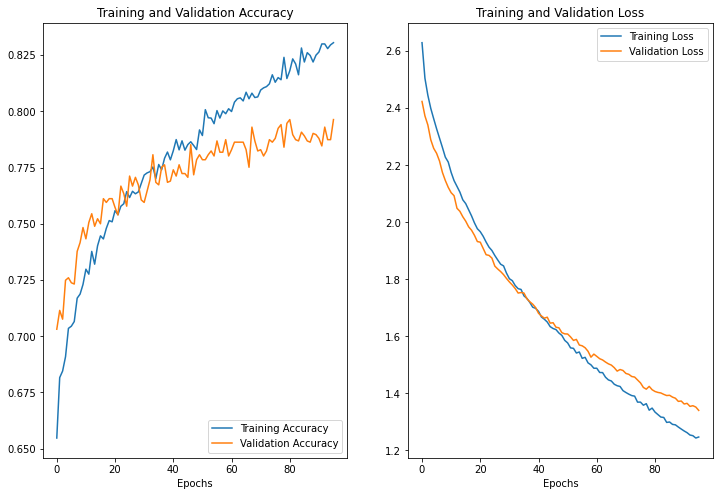

 20%|███████████████▌                                                              | 1/5 [2:05:29<8:21:58, 7529.56s/it]

 --- KFold Iteration 2 --- 
Epoch 1/150
226/226 [==============================] - 83s 363ms/step - loss: 2.6337 - accuracy: 0.6541 - val_loss: 2.4492 - val_accuracy: 0.7009
Epoch 2/150
226/226 [==============================] - 82s 361ms/step - loss: 2.4966 - accuracy: 0.6816 - val_loss: 2.3824 - val_accuracy: 0.7093
Epoch 3/150
226/226 [==============================] - 82s 361ms/step - loss: 2.4384 - accuracy: 0.6872 - val_loss: 2.3268 - val_accuracy: 0.7182
Epoch 4/150
226/226 [==============================] - 82s 361ms/step - loss: 2.3821 - accuracy: 0.7010 - val_loss: 2.2915 - val_accuracy: 0.7282
Epoch 5/150
226/226 [==============================] - 82s 362ms/step - loss: 2.3466 - accuracy: 0.7068 - val_loss: 2.2561 - val_accuracy: 0.7333
Epoch 6/150
226/226 [==============================] - 82s 361ms/step - loss: 2.3139 - accuracy: 0.7160 - val_loss: 2.2251 - val_accuracy: 0.7539
Epoch 7/150
226/226 [==============================] - 82s 361ms/step - loss: 2.2676 - accuracy:

226/226 [==============================] - 82s 360ms/step - loss: 1.5452 - accuracy: 0.7949 - val_loss: 1.5461 - val_accuracy: 0.7930
Epoch Length        : 56
Model Accuracy      : 0.8094
Validation Accuracy : 0.7963


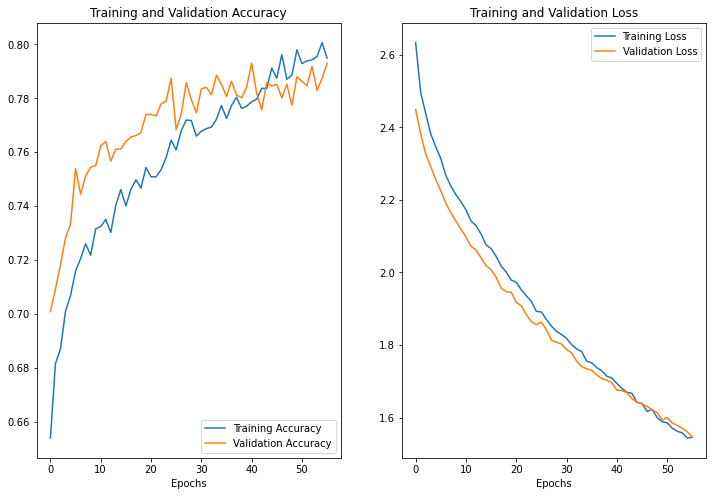

 40%|███████████████████████████████▏                                              | 2/5 [3:23:19<4:52:23, 5847.72s/it]

 --- KFold Iteration 3 --- 
Epoch 1/150
226/226 [==============================] - 89s 390ms/step - loss: 2.6440 - accuracy: 0.6606 - val_loss: 2.4947 - val_accuracy: 0.6802
Epoch 2/150
226/226 [==============================] - 88s 389ms/step - loss: 2.5289 - accuracy: 0.6753 - val_loss: 2.4263 - val_accuracy: 0.6914
Epoch 3/150
226/226 [==============================] - 88s 390ms/step - loss: 2.4720 - accuracy: 0.6863 - val_loss: 2.3992 - val_accuracy: 0.6897
Epoch 4/150
226/226 [==============================] - 88s 390ms/step - loss: 2.4250 - accuracy: 0.6901 - val_loss: 2.3361 - val_accuracy: 0.7031
Epoch 5/150
226/226 [==============================] - 88s 390ms/step - loss: 2.3977 - accuracy: 0.6927 - val_loss: 2.3359 - val_accuracy: 0.6925
Epoch 6/150
226/226 [==============================] - 88s 390ms/step - loss: 2.3544 - accuracy: 0.6960 - val_loss: 2.2952 - val_accuracy: 0.7026
Epoch 7/150
226/226 [==============================] - 89s 391ms/step - loss: 2.3249 - accuracy:

226/226 [==============================] - 88s 388ms/step - loss: 1.5302 - accuracy: 0.7917 - val_loss: 1.5310 - val_accuracy: 0.7846
Epoch 57/150
226/226 [==============================] - 88s 389ms/step - loss: 1.5150 - accuracy: 0.7906 - val_loss: 1.5328 - val_accuracy: 0.7829
Epoch 58/150
226/226 [==============================] - 88s 389ms/step - loss: 1.4996 - accuracy: 0.7966 - val_loss: 1.5284 - val_accuracy: 0.7790
Epoch 59/150
226/226 [==============================] - 88s 390ms/step - loss: 1.4925 - accuracy: 0.7943 - val_loss: 1.5272 - val_accuracy: 0.7840
Epoch 60/150
226/226 [==============================] - 88s 389ms/step - loss: 1.4966 - accuracy: 0.7907 - val_loss: 1.5132 - val_accuracy: 0.7829
Epoch 61/150
226/226 [==============================] - 88s 389ms/step - loss: 1.4756 - accuracy: 0.8031 - val_loss: 1.5000 - val_accuracy: 0.7812
Epoch 62/150
226/226 [==============================] - 88s 388ms/step - loss: 1.4743 - accuracy: 0.7971 - val_loss: 1.5055 - val_a

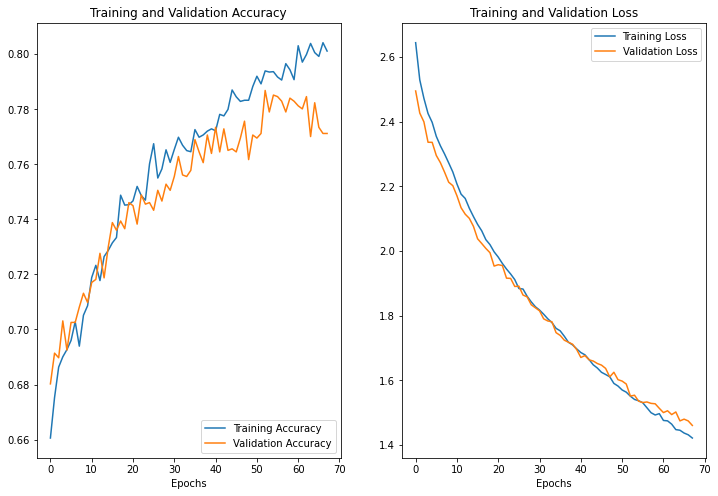

 60%|██████████████████████████████████████████████▊                               | 3/5 [5:05:04<3:18:49, 5964.97s/it]

 --- KFold Iteration 4 --- 
Epoch 1/150
226/226 [==============================] - 95s 417ms/step - loss: 2.6172 - accuracy: 0.6622 - val_loss: 2.4969 - val_accuracy: 0.6730
Epoch 2/150
226/226 [==============================] - 94s 416ms/step - loss: 2.4987 - accuracy: 0.6823 - val_loss: 2.4467 - val_accuracy: 0.6752
Epoch 3/150
226/226 [==============================] - 95s 418ms/step - loss: 2.4462 - accuracy: 0.6879 - val_loss: 2.4153 - val_accuracy: 0.6780
Epoch 4/150
226/226 [==============================] - 95s 418ms/step - loss: 2.4066 - accuracy: 0.6959 - val_loss: 2.3711 - val_accuracy: 0.6936
Epoch 5/150
226/226 [==============================] - 94s 416ms/step - loss: 2.3699 - accuracy: 0.7002 - val_loss: 2.3325 - val_accuracy: 0.6981
Epoch 6/150
226/226 [==============================] - 95s 418ms/step - loss: 2.3358 - accuracy: 0.7050 - val_loss: 2.2942 - val_accuracy: 0.6936
Epoch 7/150
226/226 [==============================] - 94s 417ms/step - loss: 2.2926 - accuracy:

226/226 [==============================] - 95s 418ms/step - loss: 1.5322 - accuracy: 0.7967 - val_loss: 1.6010 - val_accuracy: 0.7600
Epoch 57/150
226/226 [==============================] - 95s 418ms/step - loss: 1.5217 - accuracy: 0.7955 - val_loss: 1.6084 - val_accuracy: 0.7584
Epoch 58/150
226/226 [==============================] - 95s 418ms/step - loss: 1.5137 - accuracy: 0.8014 - val_loss: 1.5931 - val_accuracy: 0.7612
Epoch 59/150
226/226 [==============================] - 94s 417ms/step - loss: 1.4935 - accuracy: 0.8040 - val_loss: 1.5970 - val_accuracy: 0.7628
Epoch 60/150
226/226 [==============================] - 95s 418ms/step - loss: 1.4931 - accuracy: 0.8018 - val_loss: 1.5743 - val_accuracy: 0.7634
Epoch 61/150
226/226 [==============================] - 95s 418ms/step - loss: 1.4951 - accuracy: 0.7949 - val_loss: 1.5825 - val_accuracy: 0.7595
Epoch 62/150
226/226 [==============================] - 94s 417ms/step - loss: 1.4787 - accuracy: 0.8021 - val_loss: 1.5634 - val_a

Epoch Length        : 111
Model Accuracy      : 0.8673
Validation Accuracy : 0.7807


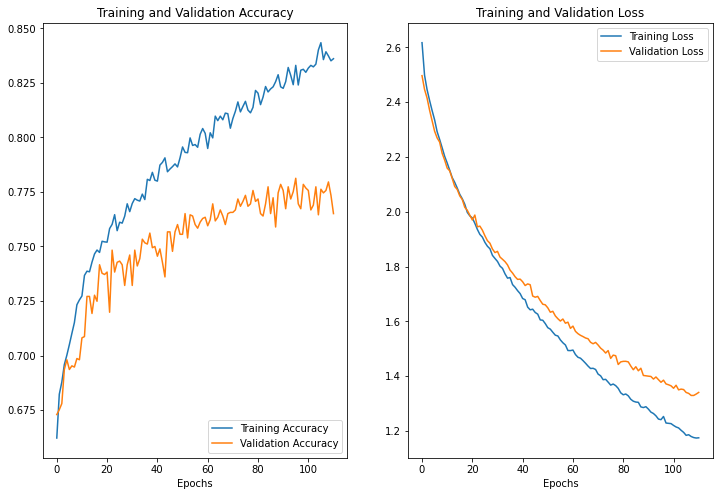

 80%|██████████████████████████████████████████████████████████████▍               | 4/5 [8:01:56<2:09:59, 7799.71s/it]

 --- KFold Iteration 5 --- 
Epoch 1/150
226/226 [==============================] - 103s 448ms/step - loss: 2.6067 - accuracy: 0.6582 - val_loss: 2.4898 - val_accuracy: 0.7070
Epoch 2/150
226/226 [==============================] - 101s 448ms/step - loss: 2.4897 - accuracy: 0.6855 - val_loss: 2.4372 - val_accuracy: 0.7070
Epoch 3/150
226/226 [==============================] - 101s 447ms/step - loss: 2.4406 - accuracy: 0.6836 - val_loss: 2.4042 - val_accuracy: 0.7121
Epoch 4/150
226/226 [==============================] - 101s 448ms/step - loss: 2.3866 - accuracy: 0.6963 - val_loss: 2.3914 - val_accuracy: 0.6987
Epoch 5/150
226/226 [==============================] - 101s 448ms/step - loss: 2.3594 - accuracy: 0.7020 - val_loss: 2.3485 - val_accuracy: 0.7165
Epoch 6/150
226/226 [==============================] - 101s 447ms/step - loss: 2.3331 - accuracy: 0.7017 - val_loss: 2.3152 - val_accuracy: 0.7188
Epoch 7/150
226/226 [==============================] - 101s 447ms/step - loss: 2.2946 - ac

226/226 [==============================] - 101s 446ms/step - loss: 1.5032 - accuracy: 0.8038 - val_loss: 1.6228 - val_accuracy: 0.7656
Epoch 57/150
226/226 [==============================] - 101s 446ms/step - loss: 1.4905 - accuracy: 0.8039 - val_loss: 1.5928 - val_accuracy: 0.7762
Epoch 58/150
226/226 [==============================] - 101s 446ms/step - loss: 1.4852 - accuracy: 0.8053 - val_loss: 1.6109 - val_accuracy: 0.7667
Epoch 59/150
226/226 [==============================] - 101s 446ms/step - loss: 1.4728 - accuracy: 0.8094 - val_loss: 1.5897 - val_accuracy: 0.7684
Epoch 60/150
226/226 [==============================] - 101s 447ms/step - loss: 1.4629 - accuracy: 0.8101 - val_loss: 1.5962 - val_accuracy: 0.7723
Epoch 61/150
226/226 [==============================] - 101s 446ms/step - loss: 1.4583 - accuracy: 0.8076 - val_loss: 1.5857 - val_accuracy: 0.7746
Epoch 62/150
226/226 [==============================] - 101s 446ms/step - loss: 1.4415 - accuracy: 0.8154 - val_loss: 1.5694 

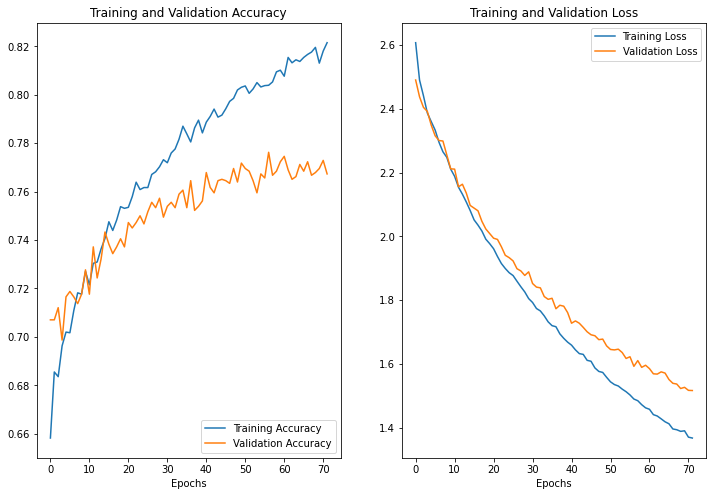

100%|███████████████████████████████████████████████████████████████████████████████| 5/5 [10:05:27<00:00, 7265.58s/it]

 === KFOLD AVERAGE STATISTICS === 
loss: 1.385972762107849 - accuracy: 0.8366154313087464 - val_loss: 1.5333009958267212 - val_accuracy: 0.78125
Time Elapsed :  10:05:29.630406


In [32]:
epochs = 150

start_time = time.time()

image_ds = tf.keras.preprocessing.image_dataset_from_directory(
    IMAGES_PATH_SEPARATED,
    image_size=IMG_SIZE,
    batch_size=32,
    shuffle=True
)

for images, labels in image_ds:
    model_input_shape = images.shape
    break
    
class_names = image_ds.class_names
num_classes = len(class_names)

statistics_data = [[],[],[],[]]

total_folds = 5 # 5
total_size = len(image_ds) 
fold_size = int(total_size / total_folds) 

if True:
    for i in tqdm(range(0, total_folds)): 
        print(" --- KFold Iteration {0} --- ".format(i+1))
        # split data looks strange but all it does 
        # it splits and shifts every iteration of the loop
        train_d_head = image_ds.take(i*fold_size)  
        rest_d = image_ds.skip(i*fold_size)
        test_d = rest_d.take(fold_size)
        train_d_tail = rest_d.skip(fold_size)
        train_d = train_d_head.concatenate(train_d_tail)
    
        # Prefetching overlaps data preprocessing and model execution while training. 
        # When model is performing training step, input pipeline is reading data for next step. 
        # This reduces each step time it takes for training and for reading.
        test_d = test_d.prefetch(buffer_size=32)
        train_d = train_d.prefetch(buffer_size=32)

        model = compile_model(model_input_shape[1:], num_classes)  # todo remove input shape
        fit_model(model, train_d, test_d, epochs, verbose=True, 
                  augment="kfold_{0}".format(i+1))

        # gather statistics
        train_evaluation = model.evaluate(train_d, verbose=0)
        validation_evaluation = model.evaluate(test_d, verbose=0)

        statistics_data[0].append(train_evaluation[0]) # loss
        statistics_data[1].append(train_evaluation[1]) # accuracy
        statistics_data[2].append(validation_evaluation[0]) # val_loss
        statistics_data[3].append(validation_evaluation[1]) # val_accuracy

    print(" === KFOLD AVERAGE STATISTICS === ")
    print("loss: {0} - accuracy: {1} - val_loss: {2} - val_accuracy: {3}".format(
        np.average(statistics_data[0]), np.average(statistics_data[1]),
        np.average(statistics_data[2]), np.average(statistics_data[3])
    ))
    print("Time Elapsed : ", timedelta(seconds=(time.time() - start_time)))



In [10]:
''' 
Add confusion matrix for models, properties such as sensitivity and ...
Try validation data
Format the code, comments
ensemble the KFold models into one

Time Elapsed :  10:05:29.630406
''';

## Single Run

Found 9013 files belonging to 7 classes.
Epoch 1/150
225/225 [==============================] - 71s 310ms/step - loss: 2.6572 - accuracy: 0.6519 - val_loss: 2.4697 - val_accuracy: 0.6878
Epoch 2/150
225/225 [==============================] - 68s 300ms/step - loss: 2.5053 - accuracy: 0.6771 - val_loss: 2.3952 - val_accuracy: 0.7093
Epoch 3/150
225/225 [==============================] - 68s 300ms/step - loss: 2.4405 - accuracy: 0.6842 - val_loss: 2.3486 - val_accuracy: 0.7154
Epoch 4/150
225/225 [==============================] - 68s 300ms/step - loss: 2.3826 - accuracy: 0.6965 - val_loss: 2.3036 - val_accuracy: 0.7253
Epoch 5/150
225/225 [==============================] - 66s 293ms/step - loss: 2.3416 - accuracy: 0.7075 - val_loss: 2.2689 - val_accuracy: 0.7308
Epoch 6/150
225/225 [==============================] - 66s 292ms/step - loss: 2.3009 - accuracy: 0.7088 - val_loss: 2.2375 - val_accuracy: 0.7292
Epoch 7/150
225/225 [==============================] - 66s 293ms/step - loss: 2.269

225/225 [==============================] - 70s 309ms/step - loss: 1.4594 - accuracy: 0.8111 - val_loss: 1.5137 - val_accuracy: 0.7777
Epoch 57/150
225/225 [==============================] - 71s 315ms/step - loss: 1.4463 - accuracy: 0.8036 - val_loss: 1.5126 - val_accuracy: 0.7766
Epoch 58/150
225/225 [==============================] - 72s 318ms/step - loss: 1.4236 - accuracy: 0.8112 - val_loss: 1.5005 - val_accuracy: 0.7832
Epoch 59/150
225/225 [==============================] - 70s 312ms/step - loss: 1.4217 - accuracy: 0.8093 - val_loss: 1.5009 - val_accuracy: 0.7777
Epoch 60/150
225/225 [==============================] - 69s 306ms/step - loss: 1.4154 - accuracy: 0.8094 - val_loss: 1.4906 - val_accuracy: 0.7755
Epoch 61/150
225/225 [==============================] - 69s 308ms/step - loss: 1.3914 - accuracy: 0.8112 - val_loss: 1.4828 - val_accuracy: 0.7843
Epoch 62/150
225/225 [==============================] - 68s 304ms/step - loss: 1.3870 - accuracy: 0.8167 - val_loss: 1.4616 - val_a

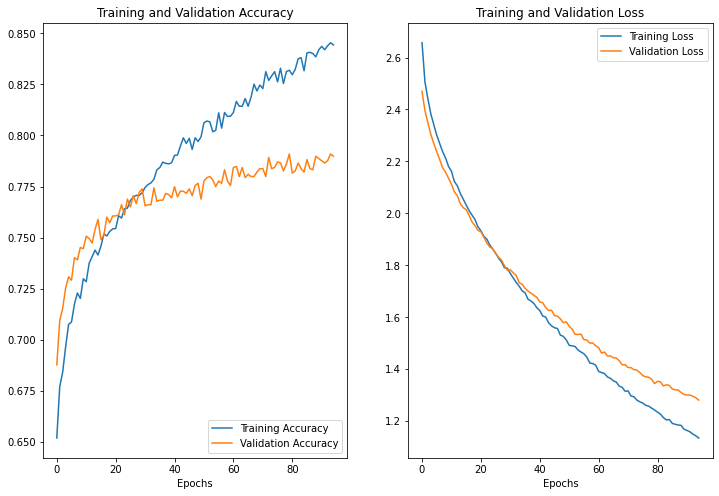

In [30]:
if True:
    image_ds = tf.keras.preprocessing.image_dataset_from_directory(
        IMAGES_PATH_SEPARATED,
        image_size=IMG_SIZE,
        batch_size=32,
        shuffle=True
    )

    epochs = 150
    split = int(len(image_ds)*0.8)
    train_d = image_ds.take(split)  
    test_d = image_ds.skip(split)

    model = compile_model(model_input_shape[1:], num_classes)  # todo remove input shape
    fit_model(model, train_d, test_d, epochs, verbose=True, 
              augment="testing_{0}".format(epochs))

## Load Existing Model

In [205]:
if True:
    model = keras.models.load_model(
        "output\keras_models\skin_classifier_56_kfold_2.keras",
        custom_objects={"mish": mish}
    )
    model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_15 (Resizing)      (None, 112, 150, 3)       0         
                                                                 
 rescaling_15 (Rescaling)    (None, 112, 150, 3)       0         
                                                                 
 conv2d_44 (Conv2D)          (None, 112, 150, 16)      448       
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 56, 75, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_45 (Conv2D)          (None, 56, 75, 32)        4640      
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 28, 37, 32)       0         
 g2D)                                                

## Display Filters

Filters     : 16
Kernel Size : (3, 3)


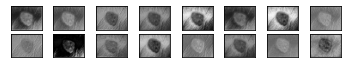

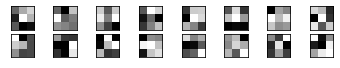

Filters     : 32
Kernel Size : (3, 3)


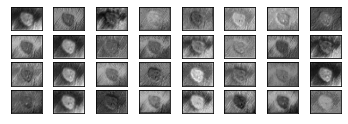

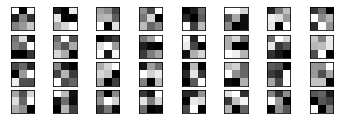

Filters     : 64
Kernel Size : (3, 3)


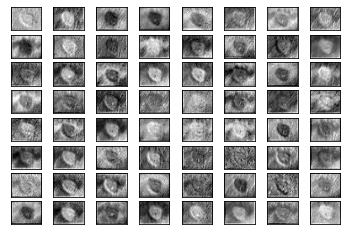

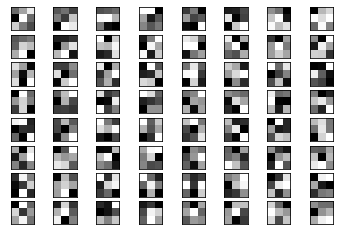

In [295]:
print_filters(model, plot_weights=True)

## Print Confusion Matrix

Found 1002 files belonging to 7 classes.
Accuracy Score :  0.7675


,precision,sensitivity,specificity,f1-score,support
0,0.4375,0.2121,0.9883,0.2857,33
1,0.4615,0.5882,0.9548,0.5172,51
2,0.5778,0.4727,0.9497,0.5200,110
3,0.0000,0.0000,1.0000,0.0000,12
4,0.6744,0.2613,0.9814,0.3766,111
5,0.8284,0.9568,0.4885,0.8880,671
6,0.6923,0.6429,0.9948,0.6667,14


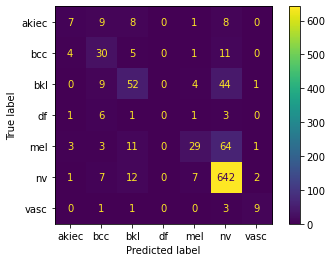

In [270]:
df_stats = print_confusion_matrix(model, IMAGES_PATH_VALIDATION)
df_stats

## Ensemble Multiple Models Weights
This approach is not working due to NV class is overrepresented

In [293]:
model_names = ["skin_classifier_96_kfold_1.keras",
               "skin_classifier_56_kfold_2.keras",
               "skin_classifier_68_kfold_3.keras",
               "skin_classifier_111_kfold_4.keras",
               "skin_classifier_72_kfold_5.keras"]
models = []
weights = [1/len(model_names) for _ in range(1, len(model_names)+1)]
for model_name in model_names:
    current_model = keras.models.load_model(
        ".\output\keras_models\\" + model_name, custom_objects={"mish": mish} )
    models.append(current_model)

# Get average weights from each layer from each model
avg_model_weights = list()
for layer in range( len(models[0].get_weights()) ):
    layer_weights = np.array([model.get_weights()[layer] for model in models])
    avg_layer_weights = np.average(layer_weights, axis=0, weights=weights)
    avg_model_weights.append(avg_layer_weights)

# ERROR:  Unknown activation function: mish. 
#         Please ensure this object is passed to the `custom_objects` argument.
# but clone_model does not support custom objects
#model_avg = keras.models.clone_model( models[0] ) #, custom_objects={"mish": mish} )

model_avg = models[0] # instead of clone_model
model_avg.set_weights(avg_model_weights)
model_avg.compile(optimizer="Adagrad",
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=["accuracy"])

Found 1002 files belonging to 7 classes.
Accuracy Score :  0.6697


,precision,sensitivity,specificity,f1-score,support
0,0.0000,0.0,1.0,0.0000,33
1,0.0000,0.0,1.0,0.0000,51
2,0.0000,0.0,1.0,0.0000,110
3,0.0000,0.0,1.0,0.0000,12
4,0.0000,0.0,1.0,0.0000,111
5,0.6697,1.0,0.0,0.8022,671
6,0.0000,0.0,1.0,0.0000,14


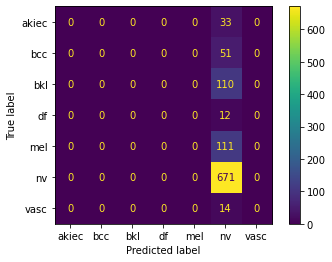

In [294]:
print_confusion_matrix(model_avg, IMAGES_PATH_VALIDATION)

Filters     : 16
Kernel Size : (3, 3)


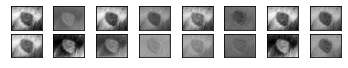

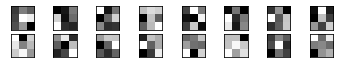

Filters     : 32
Kernel Size : (3, 3)


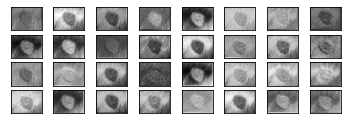

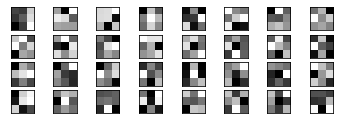

Filters     : 64
Kernel Size : (3, 3)


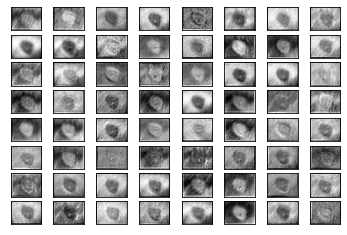

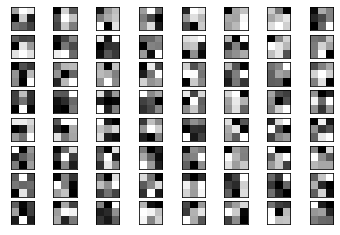

In [296]:
print_filters(model_avg, plot_weights=True)

In [ ]:
if not;

ann = Sequential()
x = layers.Conv2D(filters=64,kernel_size=(5,5),input_shape=(32,32,3))
ann.add(x)
ann.add(layers.Activation("relu"))

x1w = x.get_weights()[0][:,:,0,:]
for i in range(1,26):
    plt.subplot(5,5,i)
    plt.imshow(x1w[:,:,i],interpolation="nearest",cmap="gray")
plt.show()

ann.fit(Xtrain, ytrain_indicator, epochs=5, batch_size=32)

x1w = x.get_weights()[0][:,:,0,:]
for i in range(1,26):
    plt.subplot(5,5,i)
    plt.imshow(x1w[:,:,i],interpolation="nearest",cmap="gray")
plt.show()

In [ ]:
'''
Time it initially took to train a network was 462s per epoch
with reduction of image size and changing layers slightly it was down to 60s

Using batch size 32, as 64 overloads RAM on PC and it freezes

462s -> 458s
217s -> 219s    Images halfed
184s -> 186s  
125s -> 123s    Images quortered
166s -> 157s 
77s  -> 60s     Network simplified, 5 KFolds instead of 10 KFolds
44s  -> 40s     Added first layer

Here beta 1 with overfitting example graph
Reducing number of learning parameters, Dropout used
Looked at various loss and cost function, changed from Relu to Mish activation
At this stage Mish activation worked better than Relu, 
noticable difference in smoothness of training and in improvement of VAL_ACC
and reduction of overfitting
[Screenshots Graphs Available]

Noticed overfitting: Looking at regularization L1 and L2
Papers point to 0.005, tried various values, stayed at 0.005
Adding Dropout with 0.3

110s -> 100s 
85s  -> 78s

Changing learning rate, as model is not training over 70% ACC after regularization
Small improvements, removing Dropout layers to counter underfitting
0.0005  : Overfitting after VAL_ACC ~75 to 85 ACC
0.00001 : Way to small, 7 epochs no improvement ACC and VAL_ACC ~66 
0.0001  : Same 

Change Layers to improve accuracy, changed filter kernel size to 7-5-3 (from 3-3-3)

Still overfitting, now ACC ~95+ VAL ~81
Changing Dropout to 0.2 - 0.5 (0.4 chosen)

Swithing back to 3-3-3 kernel sizes.

Network is strugling to learn above 70 (with mish and L2 and Dropout)

Adding Batch Normalization Layer, several at the time, 
combined with few Conv layers then BN or each Conv layer with it's own,
as result removed 2 dropout layers 
as BN works better with several convolutions without dropout beforehand PROVE ME!!!

Tried to changed MaxPolling to AveragePolling, but went back as no advantages noticed

90s -> 89s

360s -> 359s

-> 90s

After changing learning rate it was noticed, 
that different learning rate works better on different epochs,
later epochs work better with larger learning rate, therefore Adagrad was implemented.

"Adagrad is an optimizer with parameter-specific learning rates, 
   which are adapted relative to how frequently a parameter gets updated during training."

Trying Adagrad + Mish 81/77 Not overfitted Good model, saved.  (Adam made it overfit)
Trying Adagrad + Relu ... 

///
''';